In [8]:
!pip install --upgrade protobuf==3.20.*


In [2]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [5]:
# CONFIG
IMG_SIZE = 120
BATCH_SIZE = 64
EPOCHS = 150
DATASET_SPLIT = 2500

BASE_DIR = "/kaggle/input/sar-opticalvvvhhhhvrgb"
VV_DIR = os.path.join(BASE_DIR, "VV")
RGB_DIR = os.path.join(BASE_DIR, "RGB_Extracted")


In [7]:
print("VV samples:", os.listdir(VV_DIR)[:5])
print("RGB samples:", os.listdir(RGB_DIR)[:5])


VV samples: ['SN6_Train_AOI_11_Rotterdam_VV_20190823082625_20190823082938_tile_442.jpg', 'SN6_Train_AOI_11_Rotterdam_VV_20190822144546_20190822144829_tile_7605.jpg', 'SN6_Train_AOI_11_Rotterdam_VV_20190822102956_20190822103254_tile_4111.jpg', 'SN6_Train_AOI_11_Rotterdam_VV_20190823094036_20190823094408_tile_10250.jpg', 'SN6_Train_AOI_11_Rotterdam_VV_20190804130422_20190804130643_tile_3181.jpg']
RGB samples: ['SN6_Train_AOI_11_Rotterdam_PS-RGB_20190823100628_20190823100943_tile_5442.jpg', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190822094951_20190822095250_tile_2955.jpg', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190822153558_20190822153835_tile_2540.jpg', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190823152527_20190823152847_tile_5820.jpg', 'SN6_Train_AOI_11_Rotterdam_PS-RGB_20190822145028_20190822145325_tile_9214.jpg']


In [8]:
print("VV count:", len(os.listdir(VV_DIR)))
print("RGB count:", len(os.listdir(RGB_DIR)))


VV count: 3401
RGB count: 3401


In [9]:
vv_sample = sorted(os.listdir(VV_DIR))[:10]
rgb_sample = sorted(os.listdir(RGB_DIR))[:10]

print("VV sample:")
for f in vv_sample:
    print(f)

print("\nRGB sample:")
for f in rgb_sample:
    print(f)


VV sample:
SN6_Train_AOI_11_Rotterdam_VV_20190804111224_20190804111453_tile_8679.jpg
SN6_Train_AOI_11_Rotterdam_VV_20190804111224_20190804111453_tile_8681.jpg
SN6_Train_AOI_11_Rotterdam_VV_20190804111224_20190804111453_tile_8683.jpg
SN6_Train_AOI_11_Rotterdam_VV_20190804111224_20190804111453_tile_8685.jpg
SN6_Train_AOI_11_Rotterdam_VV_20190804111224_20190804111453_tile_8687.jpg
SN6_Train_AOI_11_Rotterdam_VV_20190804111224_20190804111453_tile_8689.jpg
SN6_Train_AOI_11_Rotterdam_VV_20190804111224_20190804111453_tile_8691.jpg
SN6_Train_AOI_11_Rotterdam_VV_20190804111224_20190804111453_tile_8693.jpg
SN6_Train_AOI_11_Rotterdam_VV_20190804111224_20190804111453_tile_8695.jpg
SN6_Train_AOI_11_Rotterdam_VV_20190804111851_20190804112030_tile_5175.jpg

RGB sample:
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8679.jpg
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8681.jpg
SN6_Train_AOI_11_Rotterdam_PS-RGB_20190804111224_20190804111453_tile_8683.jpg
SN

In [11]:
def extract_key(filename):
    parts = filename.split("_")
    return "_".join(parts[-3:]).replace(".jpg", "")


In [12]:
x, y = [], []

vv_files = os.listdir(VV_DIR)
rgb_files = os.listdir(RGB_DIR)

# Build RGB lookup using extracted key
rgb_lookup = {}
for f in rgb_files:
    key = extract_key(f)
    rgb_lookup[key] = f

# Match VV to RGB
for vv_file in vv_files:
    key = extract_key(vv_file)

    if key not in rgb_lookup:
        continue

    vv_path = os.path.join(VV_DIR, vv_file)
    rgb_path = os.path.join(RGB_DIR, rgb_lookup[key])

    vv_img = Image.open(vv_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
    vv_arr = np.asarray(vv_img).reshape(IMG_SIZE, IMG_SIZE, 1) / 255.0

    rgb_img = Image.open(rgb_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    rgb_arr = np.asarray(rgb_img) / 255.0

    x.append(vv_arr)
    y.append(rgb_arr)

print("✅ Loaded paired images:", len(x))


✅ Loaded paired images: 3401


In [13]:
from sklearn.model_selection import train_test_split

x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

train_x, test_x, train_y, test_y = train_test_split(
    x, y, test_size=0.1, random_state=42
)

dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.shuffle(1000).batch(BATCH_SIZE)


I0000 00:00:1766546873.782838      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766546873.783491      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [14]:
def get_generator():
    inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 1))

    # Encoder
    c1 = tf.keras.layers.Conv2D(32, 5, padding="same")(inputs)
    c1 = tf.keras.layers.LeakyReLU()(c1)

    c2 = tf.keras.layers.Conv2D(64, 3, padding="same")(c1)
    c2 = tf.keras.layers.LeakyReLU()(c2)

    c3 = tf.keras.layers.Conv2D(128, 3, padding="same")(c2)
    c3 = tf.keras.layers.LeakyReLU()(c3)

    # Bottleneck
    b = tf.keras.layers.Conv2D(128, 3, padding="same", activation="tanh")(c3)

    # Decoder (skip connections)
    u1 = tf.keras.layers.Concatenate()([b, c3])
    u1 = tf.keras.layers.Conv2DTranspose(128, 3, padding="same", activation="relu")(u1)

    u2 = tf.keras.layers.Concatenate()([u1, c2])
    u2 = tf.keras.layers.Conv2DTranspose(64, 3, padding="same", activation="relu")(u2)

    u3 = tf.keras.layers.Concatenate()([u2, c1])
    outputs = tf.keras.layers.Conv2DTranspose(
        3, 5, padding="same", activation="sigmoid"
    )(u3)

    return tf.keras.Model(inputs, outputs)


In [15]:
def get_discriminator():
    inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))

    x = tf.keras.layers.Conv2D(64, 5, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(256, activation="relu")(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    return tf.keras.Model(inputs, outputs)


In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(fake, real):
    l1 = tf.reduce_mean(tf.abs(fake - real))
    ssim = 1 - tf.reduce_mean(tf.image.ssim(fake, real, max_val=1.0))
    return l1 + 0.5 * ssim

def discriminator_loss(real, fake):
    real_loss = cross_entropy(tf.ones_like(real), real)
    fake_loss = cross_entropy(tf.zeros_like(fake), fake)
    return real_loss + fake_loss


In [17]:
generator = get_generator()
discriminator = get_discriminator()

gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [18]:
@tf.function
def train_step(vv, rgb):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_rgb = generator(vv, training=True)

        real_out = discriminator(rgb, training=True)
        fake_out = discriminator(fake_rgb, training=True)

        gen_loss = generator_loss(fake_rgb, rgb)
        disc_loss = discriminator_loss(real_out, fake_out)

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))


In [19]:
EPOCHS = 150

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for vv, rgb in dataset:
        train_step(vv, rgb)


Epoch 1/150


I0000 00:00:1766547222.266215     136 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 2/150
Epoch 3/150
Epoch 4/150
Epoch 5/150
Epoch 6/150
Epoch 7/150
Epoch 8/150
Epoch 9/150
Epoch 10/150
Epoch 11/150
Epoch 12/150
Epoch 13/150
Epoch 14/150
Epoch 15/150
Epoch 16/150
Epoch 17/150
Epoch 18/150
Epoch 19/150
Epoch 20/150
Epoch 21/150
Epoch 22/150
Epoch 23/150
Epoch 24/150
Epoch 25/150
Epoch 26/150
Epoch 27/150
Epoch 28/150
Epoch 29/150
Epoch 30/150
Epoch 31/150
Epoch 32/150
Epoch 33/150
Epoch 34/150
Epoch 35/150
Epoch 36/150
Epoch 37/150
Epoch 38/150
Epoch 39/150
Epoch 40/150
Epoch 41/150
Epoch 42/150
Epoch 43/150
Epoch 44/150
Epoch 45/150
Epoch 46/150
Epoch 47/150
Epoch 48/150
Epoch 49/150
Epoch 50/150
Epoch 51/150
Epoch 52/150
Epoch 53/150
Epoch 54/150
Epoch 55/150
Epoch 56/150
Epoch 57/150
Epoch 58/150
Epoch 59/150
Epoch 60/150
Epoch 61/150
Epoch 62/150
Epoch 63/150
Epoch 64/150
Epoch 65/150
Epoch 66/150
Epoch 67/150
Epoch 68/150
Epoch 69/150
Epoch 70/150
Epoch 71/150
Epoch 72/150
Epoch 73/150
Epoch 74/150
Epoch 75/150
Epoch 76/150
Epoch 77/150
Epoch 78/150
Epoch 7

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


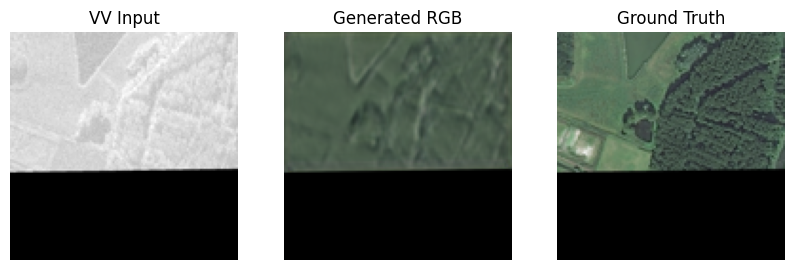

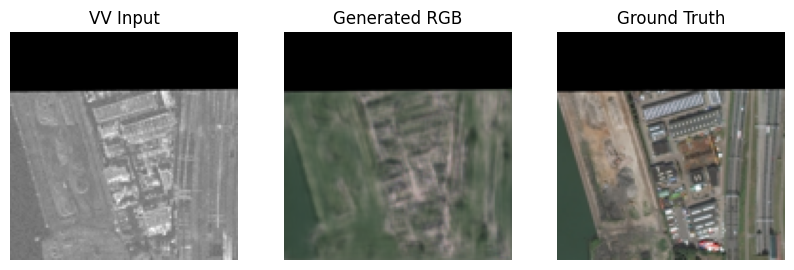

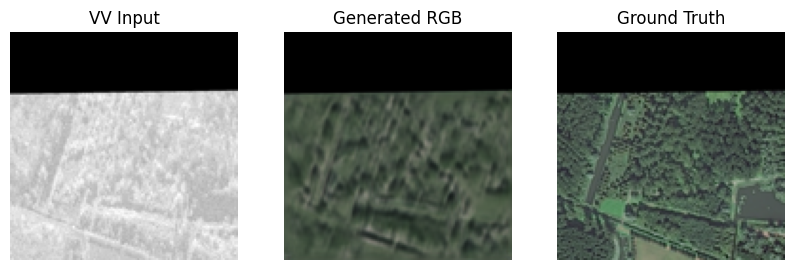

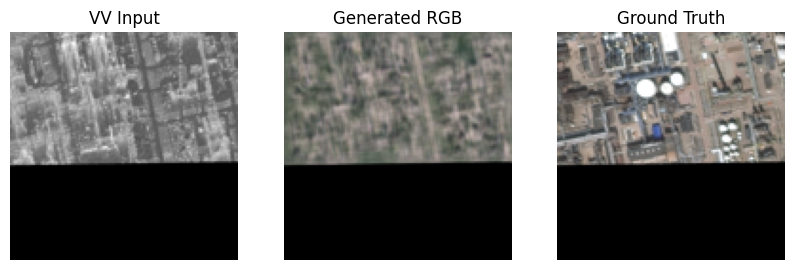

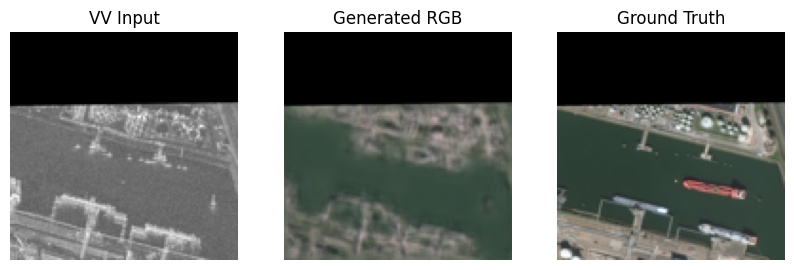

In [23]:
pred = generator.predict(test_x[:20], batch_size=1)

for i in range(5):
    plt.figure(figsize=(10,3))

    plt.subplot(1,3,1)
    plt.title("VV Input")
    plt.imshow(test_x[i].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Generated RGB")
    plt.imshow(pred[i])
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Ground Truth")
    plt.imshow(test_y[i])
    plt.axis("off")

    plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


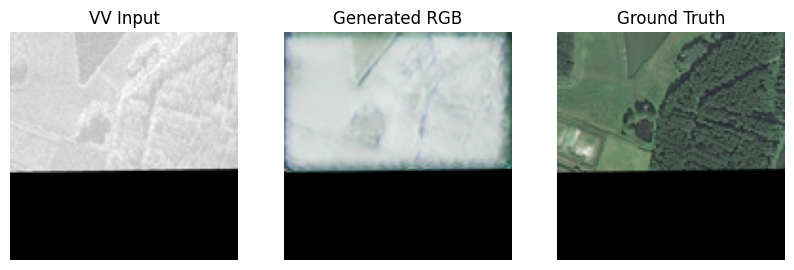

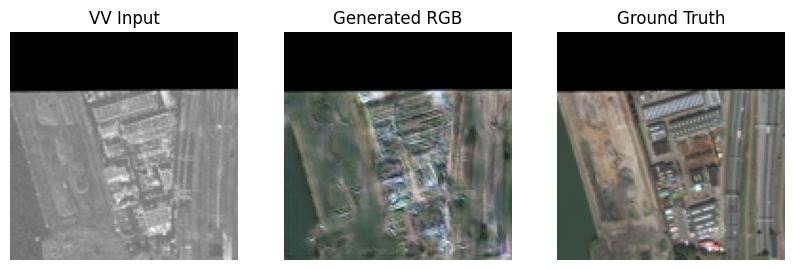

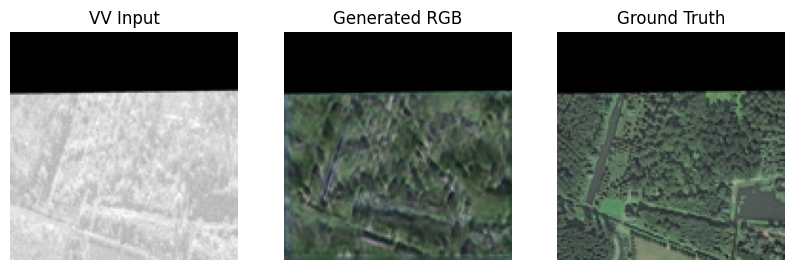

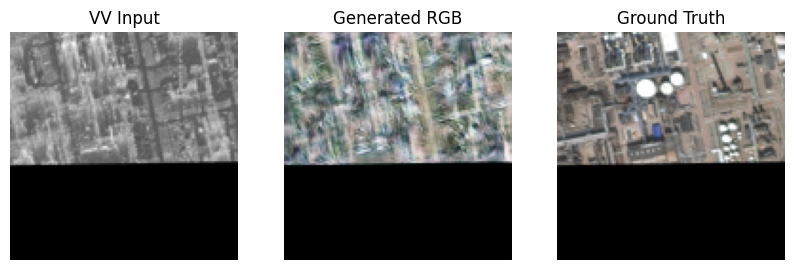

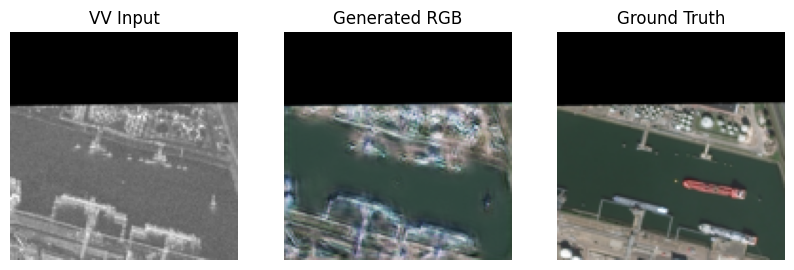

In [68]:
pred = generator.predict(test_x[:20], batch_size=1)

for i in range(5):
    plt.figure(figsize=(10,3))

    plt.subplot(1,3,1)
    plt.title("VV Input")
    plt.imshow(test_x[i].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Generated RGB")
    plt.imshow(pred[i])
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Ground Truth")
    plt.imshow(test_y[i])
    plt.axis("off")

    plt.show()


In [24]:
generator.save("generator_model.keras")


In [25]:
import tensorflow as tf

generator = tf.keras.models.load_model(
    "/kaggle/working/generator_model.keras",
    compile=False   # important for inference-only
)

print("✅ Model loaded successfully")
generator.summary()


✅ Model loaded successfully


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 120, 120,  │        832 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 120, 120,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 120, 120,  │     18,496 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 120, 120,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 120, 120,  │     73,856 │ leaky_re_lu_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 120, 120,  │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 120, 120,  │    147,584 │ leaky_re_lu_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 120, 120,  │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 120, 120,  │    295,040 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 120, 120,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 192)              │            │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 120, 120,  │    110,656 │ concatenate_1[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 120, 120,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 96)               │            │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 120, 120,  │      7,203 │ concatenate_2[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 653,667 (2.49 MB)

 Trainable params: 653,667 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
BATCH_SIZE = 4   # keep small to avoid OOM

pred = generator.predict(
    test_x,
    batch_size=BATCH_SIZE,
    verbose=1
)


86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


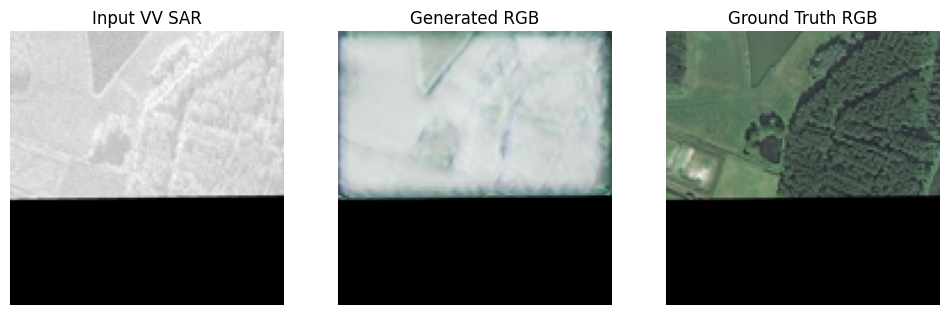

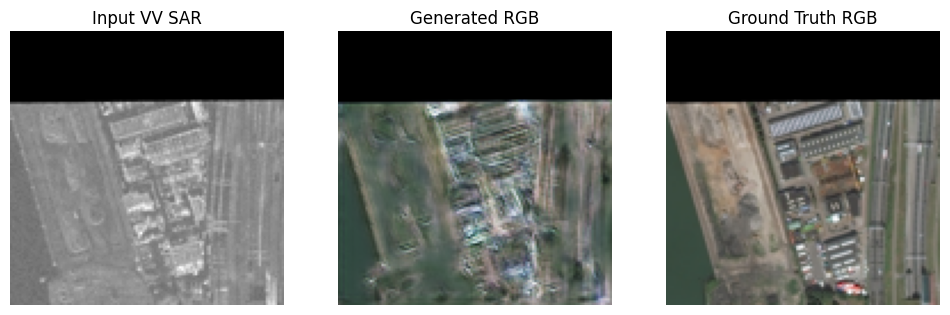

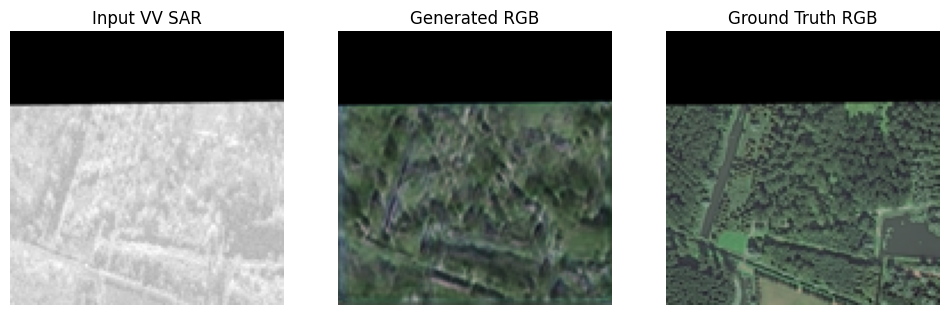

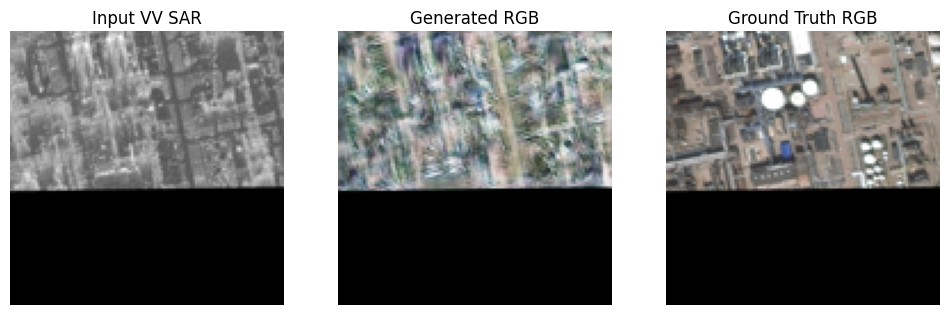

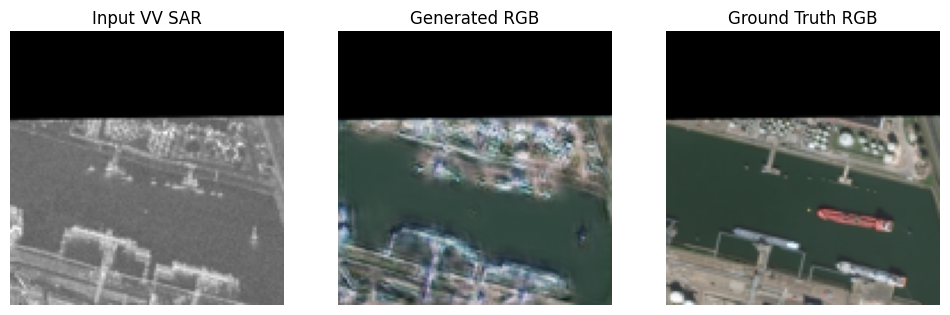

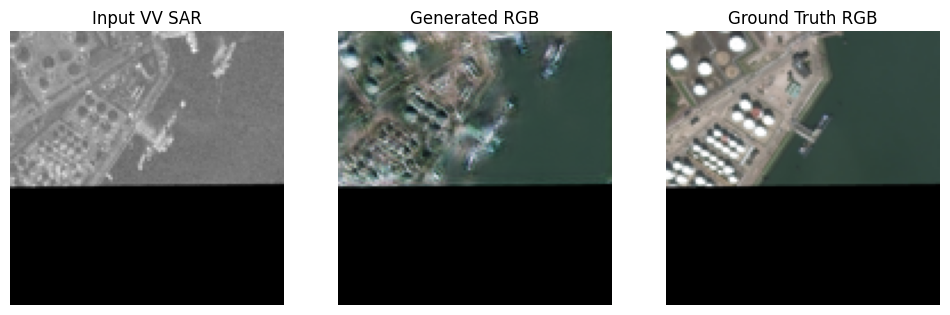

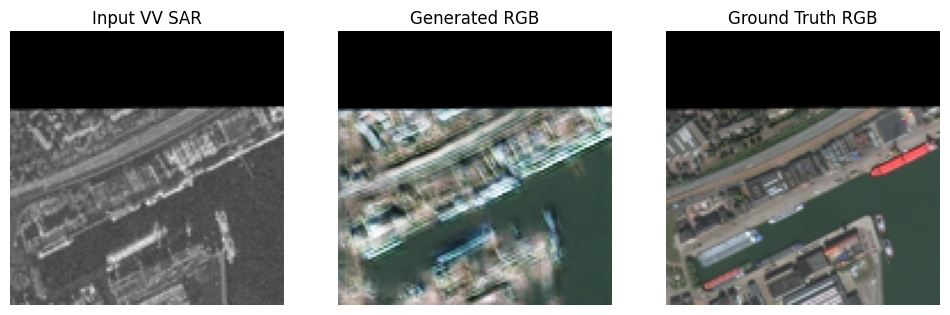

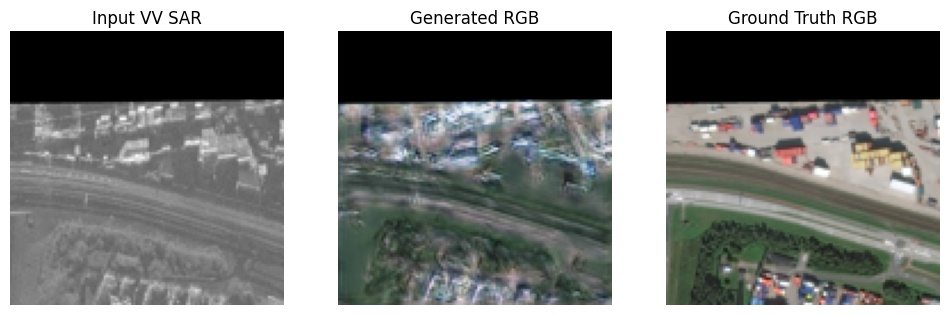

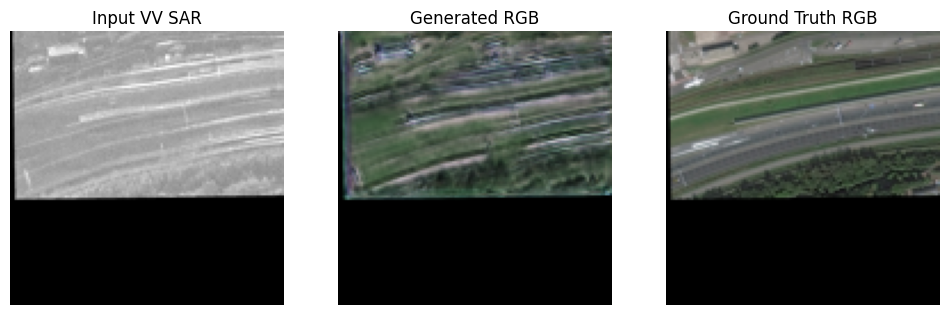

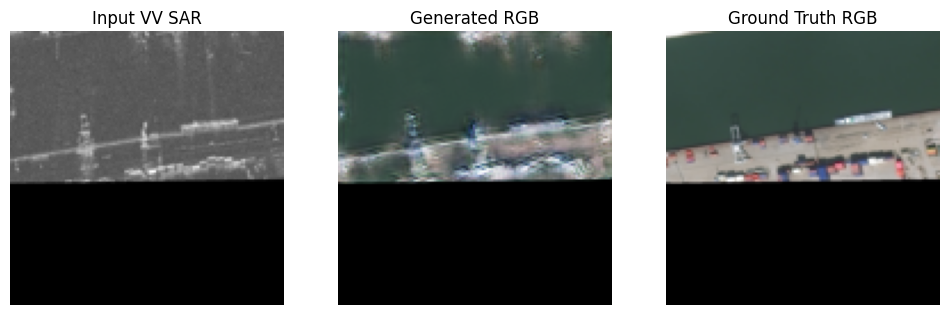

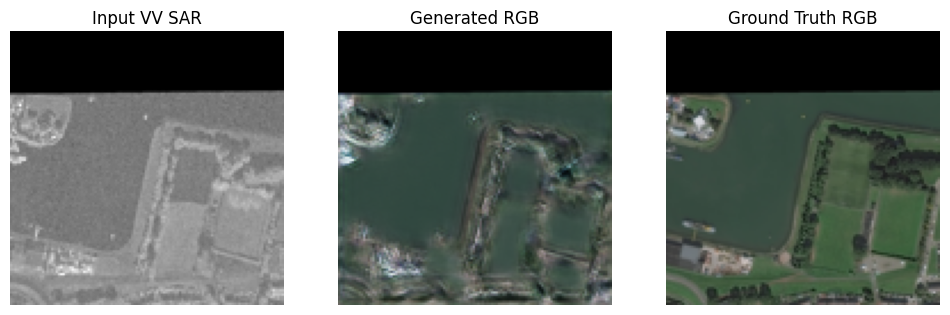

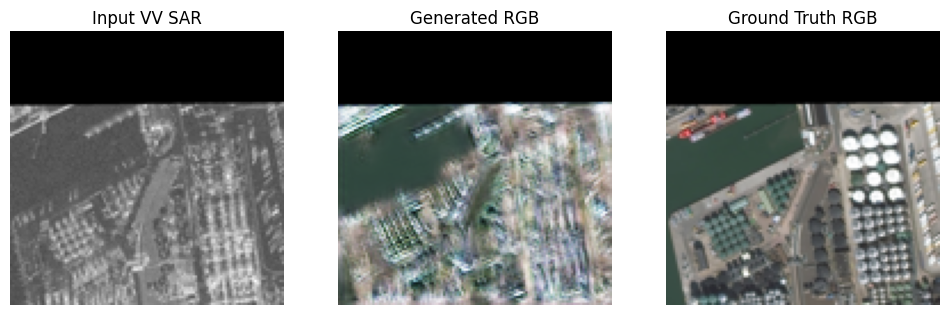

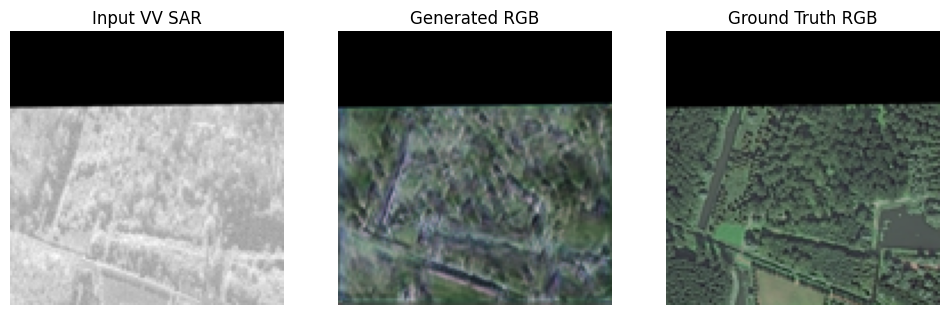

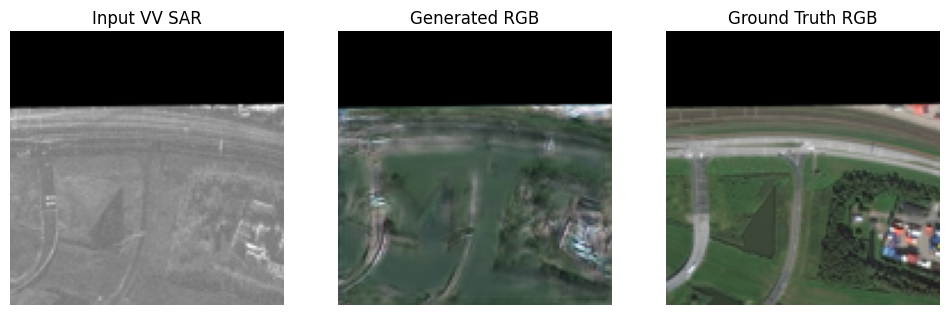

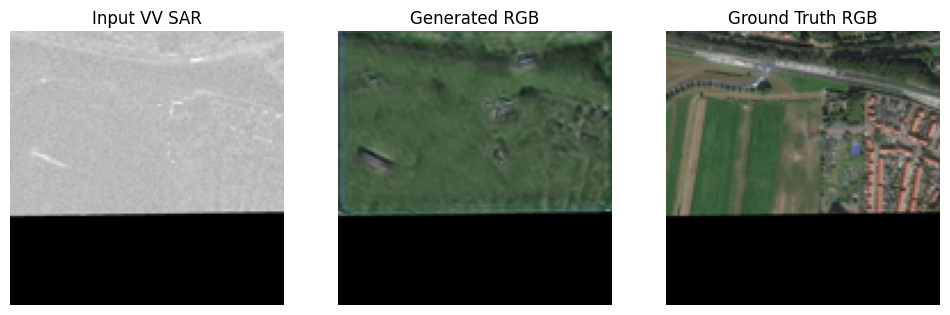

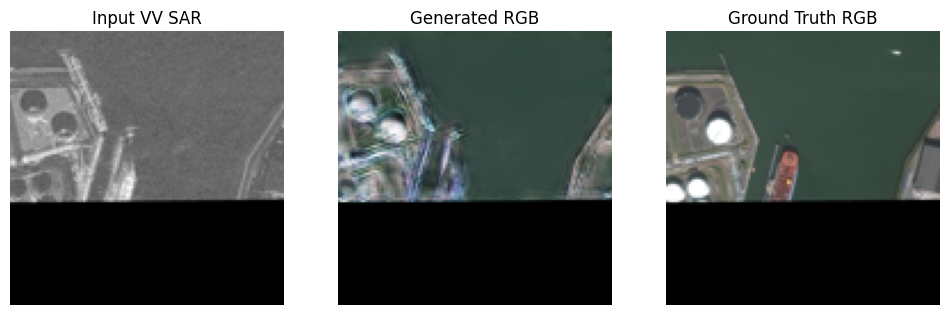

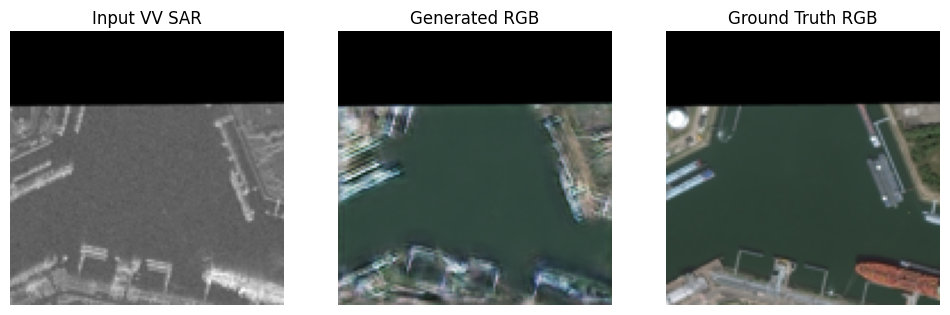

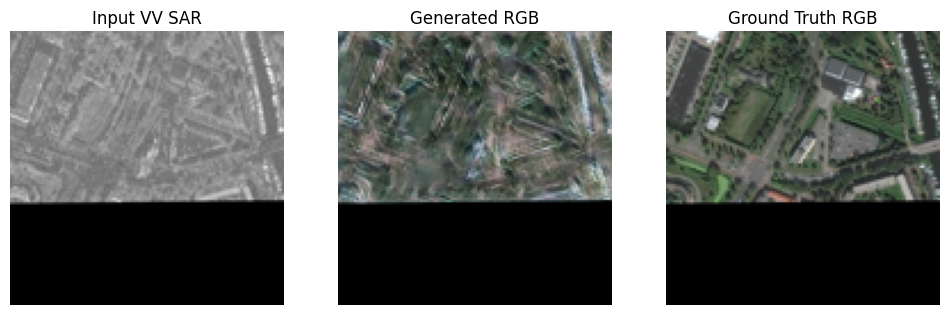

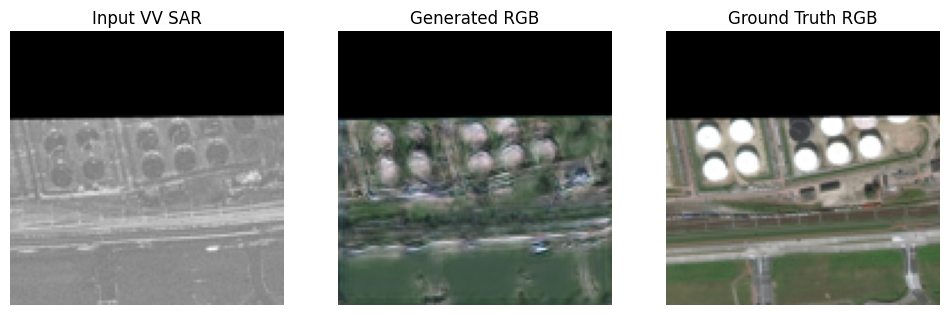

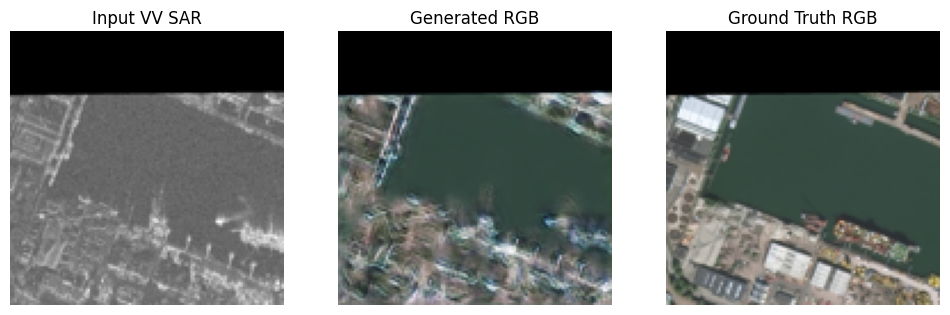

In [67]:
import matplotlib.pyplot as plt

for i in range(20):
    plt.figure(figsize=(12,4))

    # Input SAR (VV)
    plt.subplot(1,3,1)
    plt.imshow(test_x[i].squeeze(), cmap="gray")
    plt.title("Input VV SAR")
    plt.axis("off")

    # Generated RGB
    plt.subplot(1,3,2)
    plt.imshow(pred[i])
    plt.title("Generated RGB")
    plt.axis("off")

    # Ground Truth RGB
    plt.subplot(1,3,3)
    plt.imshow(test_y[i])
    plt.title("Ground Truth RGB")
    plt.axis("off")

    plt.show()


In [44]:
generator = tf.keras.models.load_model(
    "generator_model.keras",
    compile=False
)


In [46]:
for layer in generator.layers:
    if "conv2d" in layer.name:
        layer.trainable = False


In [55]:
# Freeze encoder only
freeze = True
for layer in generator.layers:
    if "conv2d_transpose" in layer.name:
        freeze = False   # decoder starts here

    layer.trainable = not freeze


In [56]:
print("Trainable variables:", len(generator.trainable_variables))


Trainable variables: 6


In [57]:
def get_discriminator():
    inp = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))

    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding="same")(inp)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(1, 4, padding="same")(x)

    return tf.keras.Model(inp, x)

discriminator = get_discriminator()


In [58]:
def sobel_loss(fake, real):
    fake_edges = tf.image.sobel_edges(fake)
    real_edges = tf.image.sobel_edges(real)
    return tf.reduce_mean(tf.abs(fake_edges - real_edges))


In [59]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake, real, fake_out):
    adv = bce(tf.ones_like(fake_out), fake_out)
    l1 = tf.reduce_mean(tf.abs(fake - real))
    ssim = 1 - tf.reduce_mean(tf.image.ssim(fake, real, max_val=1.0))
    edge = sobel_loss(fake, real)

    return (
        0.5 * adv +      # gentle GAN pressure
        20 * l1 +        # preserve colors
        10 * edge +      # sharpen contours
        5 * ssim
    )


In [61]:
gen_optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-5, beta_1=0.5
)

disc_optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4, beta_1=0.5
)


In [62]:
@tf.function
def train_step(vv, rgb):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_rgb = generator(vv, training=True)

        real_out = discriminator(rgb, training=True)
        fake_out = discriminator(fake_rgb, training=True)

        gen_loss = generator_loss(fake_rgb, rgb, fake_out)
        disc_loss = (
            bce(tf.ones_like(real_out), real_out) +
            bce(tf.zeros_like(fake_out), fake_out)
        )

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))


In [63]:
FINE_TUNE_EPOCHS = 40

for epoch in range(FINE_TUNE_EPOCHS):
    print(f"Fine-tuning Epoch {epoch+1}/{FINE_TUNE_EPOCHS}")
    for vv, rgb in dataset:
        train_step(vv, rgb)


Fine-tuning Epoch 1/40
Fine-tuning Epoch 2/40
Fine-tuning Epoch 3/40
Fine-tuning Epoch 4/40
Fine-tuning Epoch 5/40
Fine-tuning Epoch 6/40
Fine-tuning Epoch 7/40
Fine-tuning Epoch 8/40
Fine-tuning Epoch 9/40
Fine-tuning Epoch 10/40
Fine-tuning Epoch 11/40
Fine-tuning Epoch 12/40
Fine-tuning Epoch 13/40
Fine-tuning Epoch 14/40
Fine-tuning Epoch 15/40
Fine-tuning Epoch 16/40
Fine-tuning Epoch 17/40
Fine-tuning Epoch 18/40
Fine-tuning Epoch 19/40
Fine-tuning Epoch 20/40
Fine-tuning Epoch 21/40
Fine-tuning Epoch 22/40
Fine-tuning Epoch 23/40
Fine-tuning Epoch 24/40
Fine-tuning Epoch 25/40
Fine-tuning Epoch 26/40
Fine-tuning Epoch 27/40
Fine-tuning Epoch 28/40
Fine-tuning Epoch 29/40
Fine-tuning Epoch 30/40
Fine-tuning Epoch 31/40
Fine-tuning Epoch 32/40
Fine-tuning Epoch 33/40
Fine-tuning Epoch 34/40
Fine-tuning Epoch 35/40
Fine-tuning Epoch 36/40
Fine-tuning Epoch 37/40
Fine-tuning Epoch 38/40
Fine-tuning Epoch 39/40
Fine-tuning Epoch 40/40


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


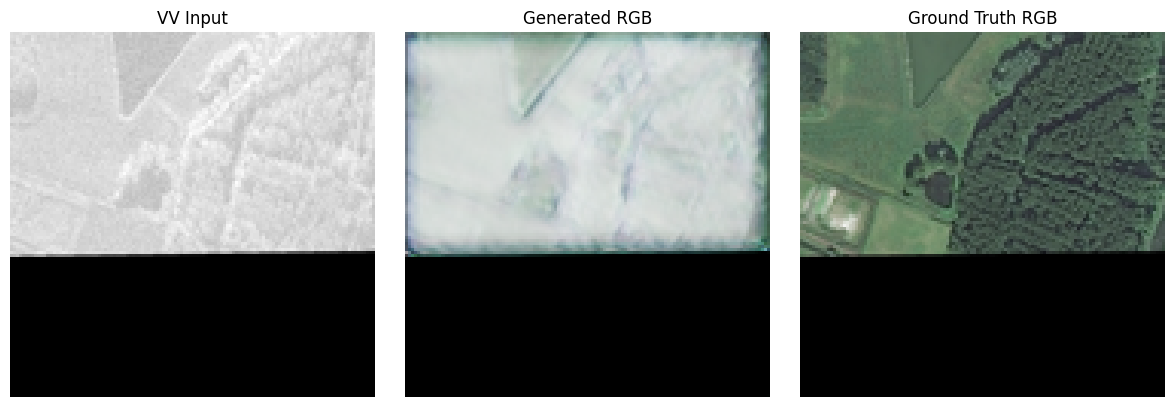

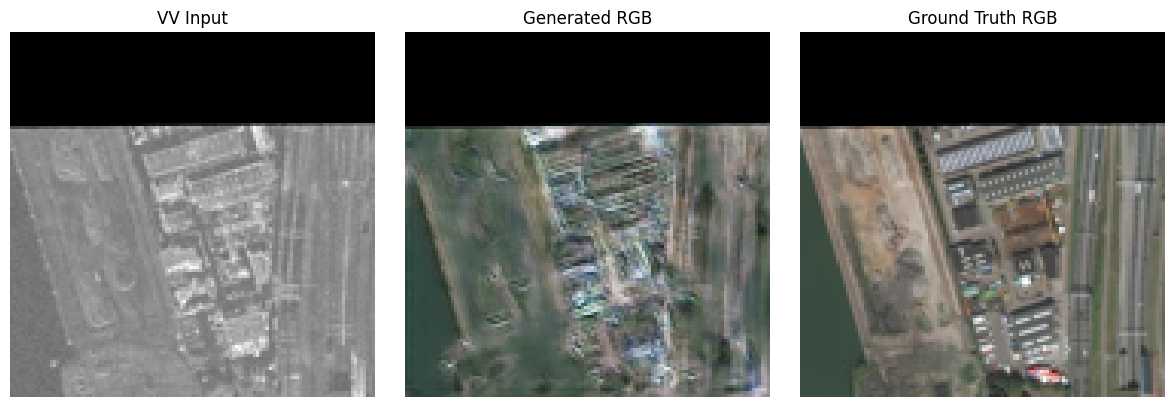

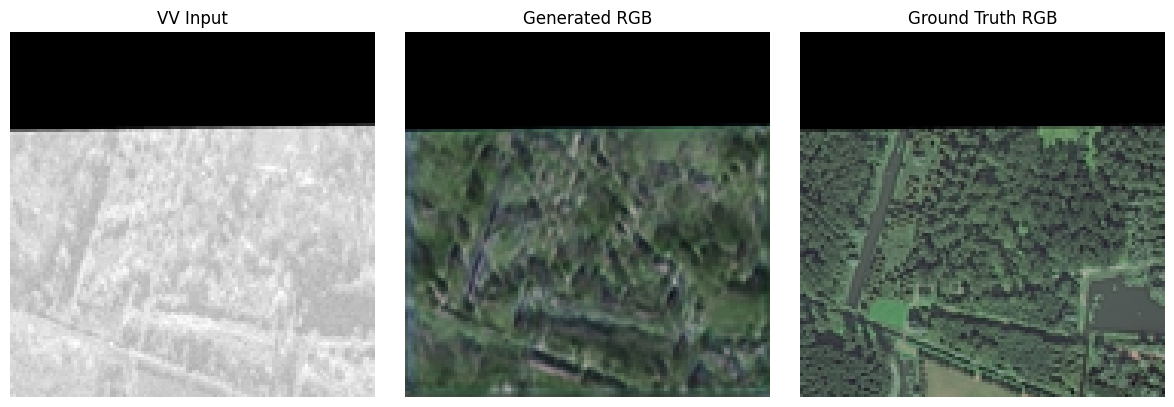

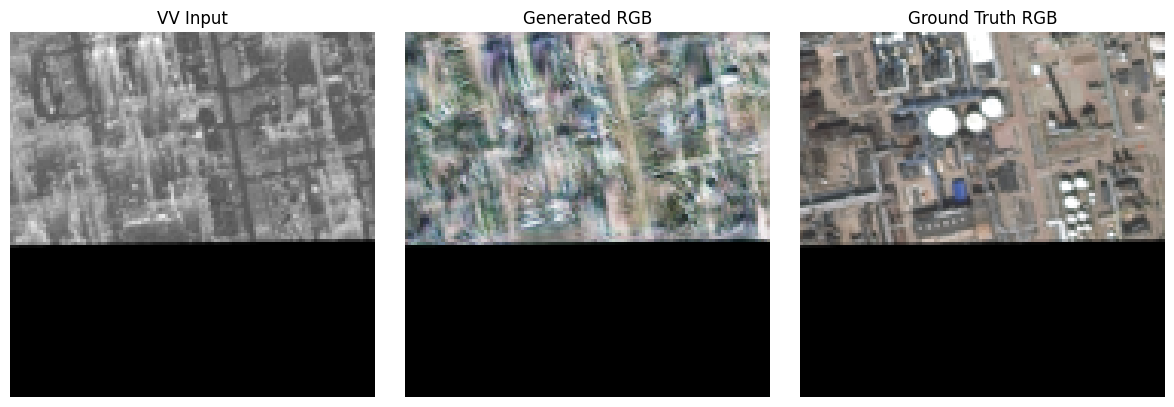

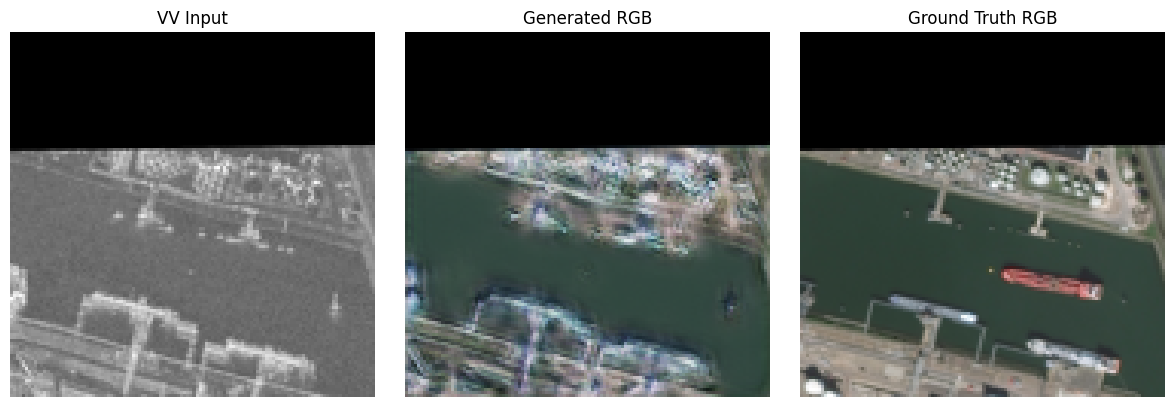

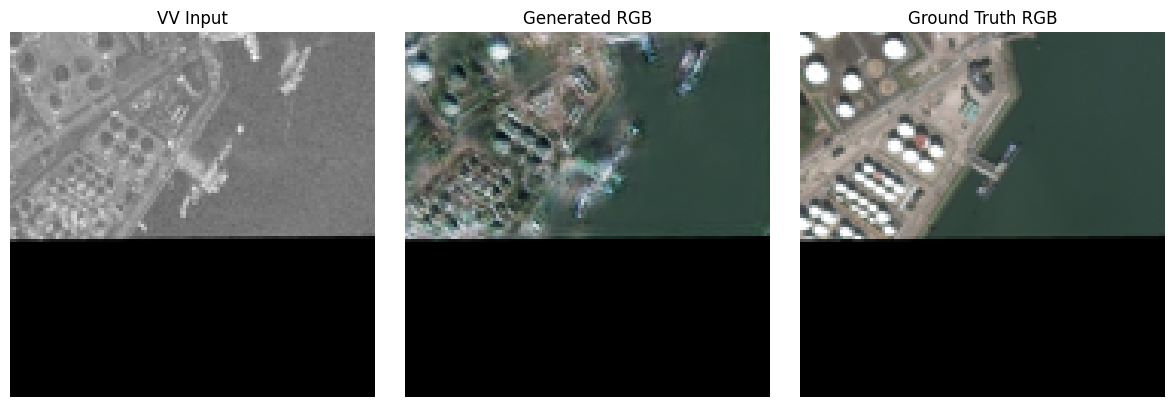

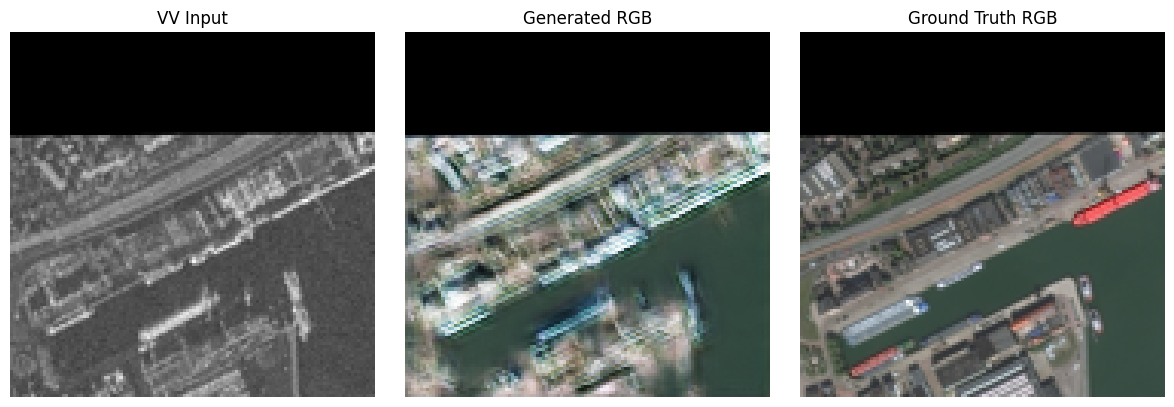

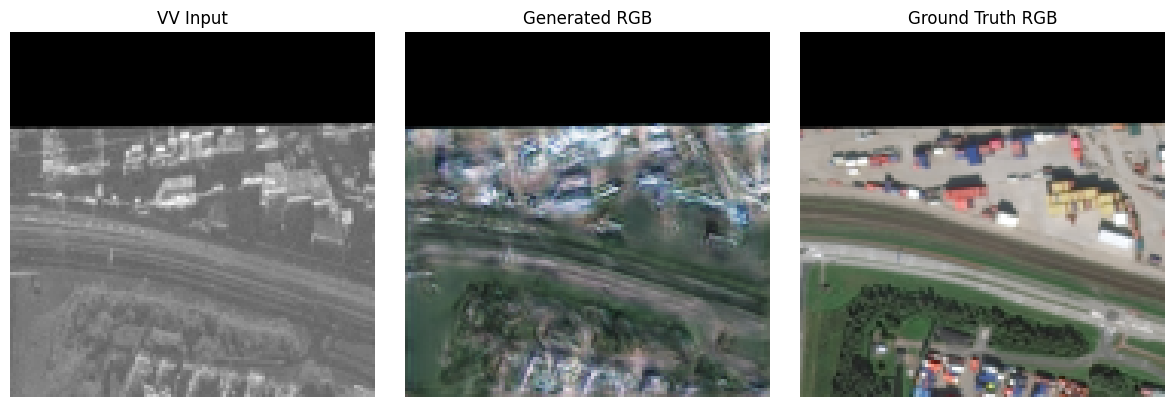

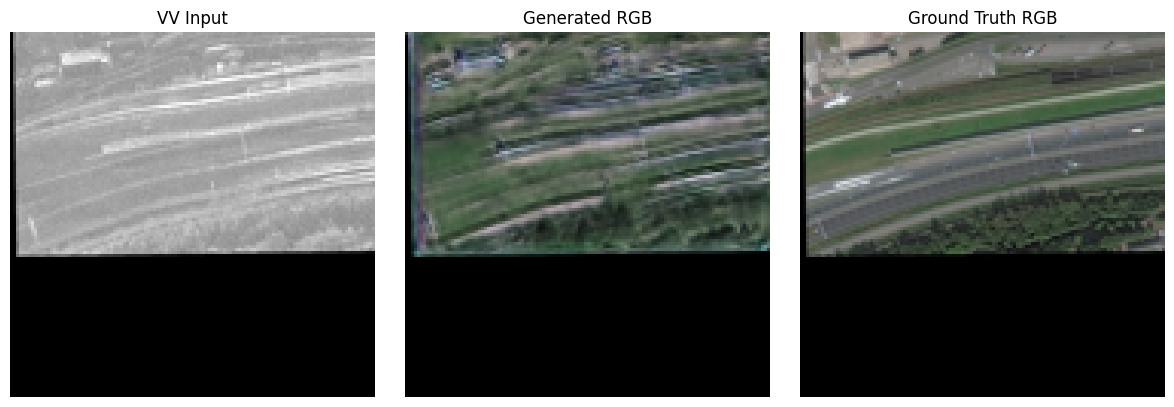

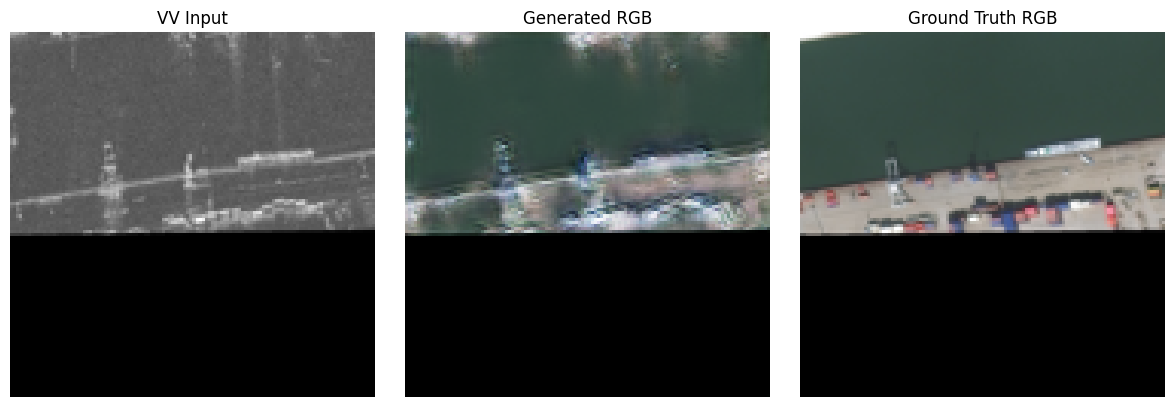

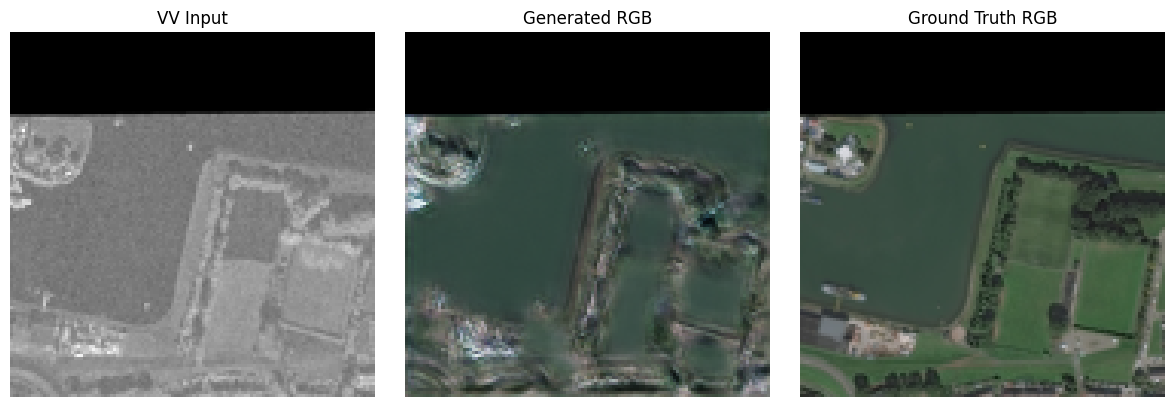

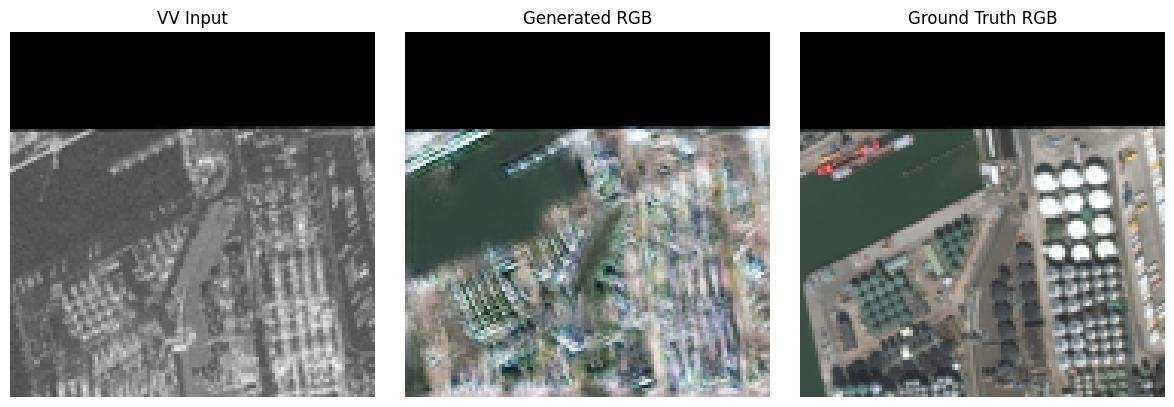

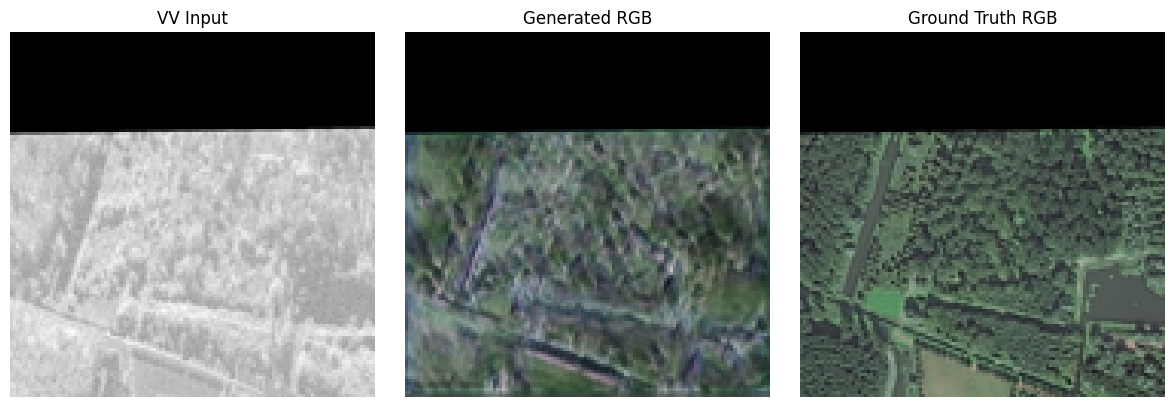

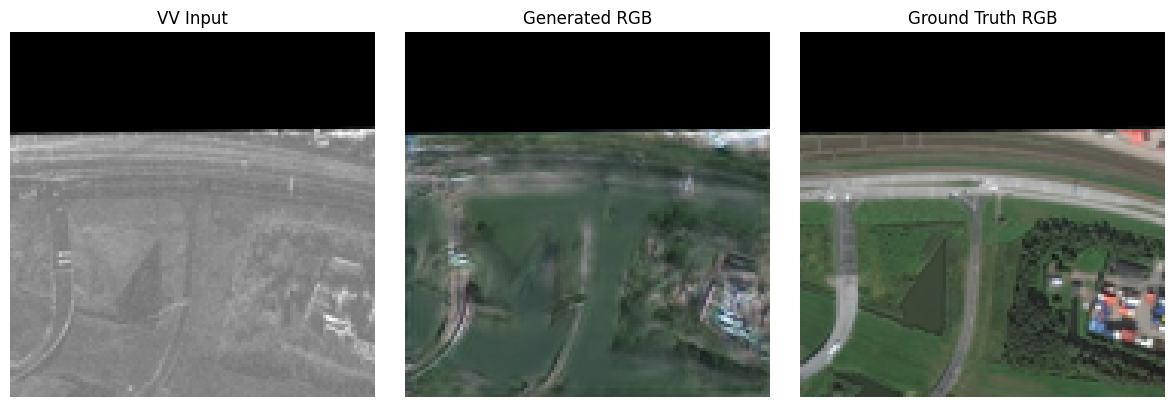

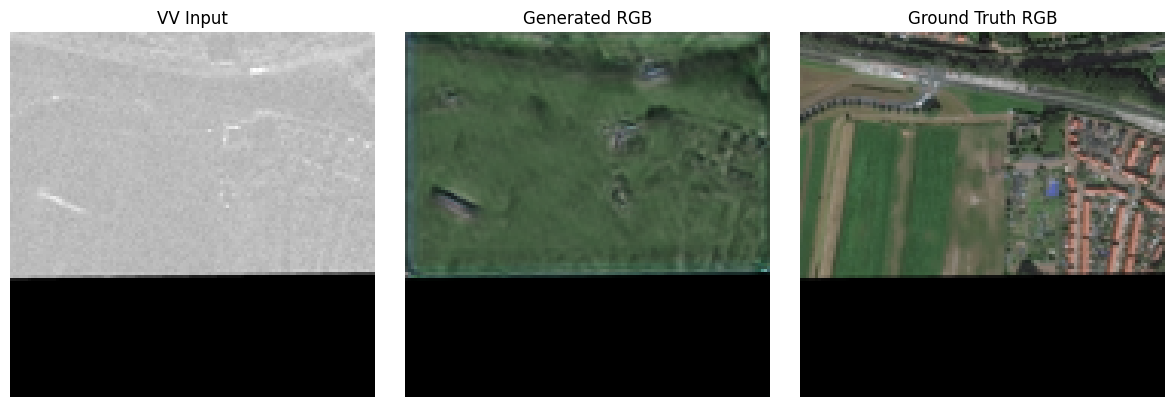

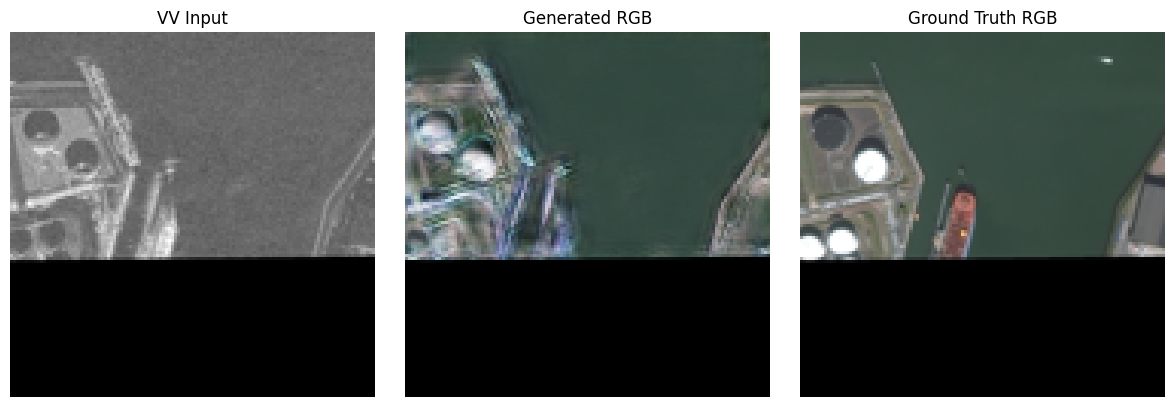

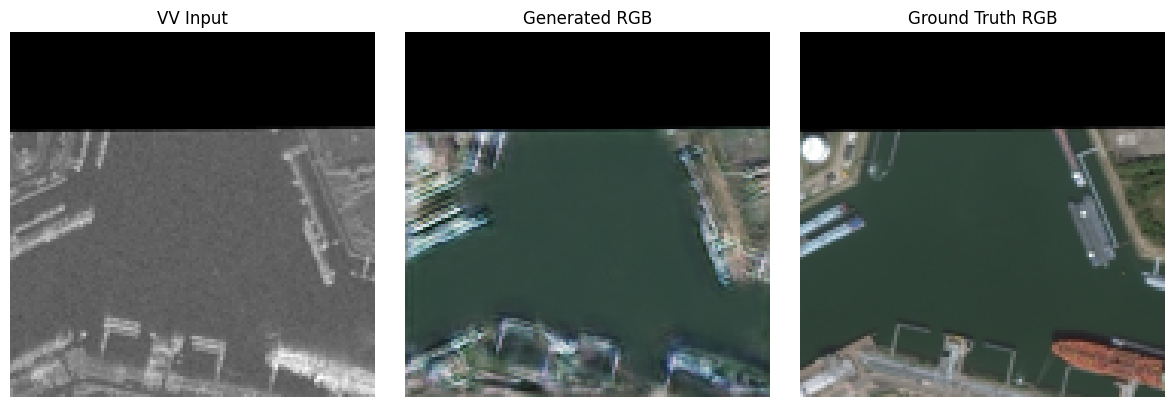

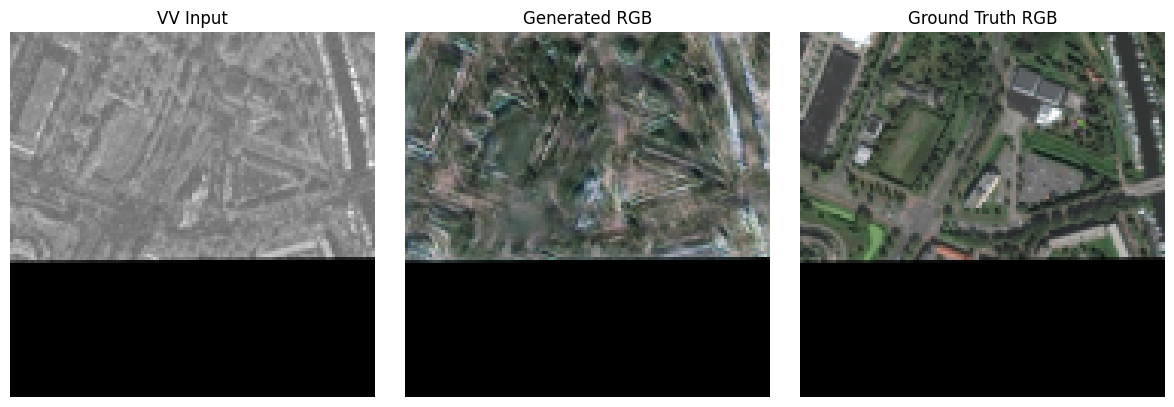

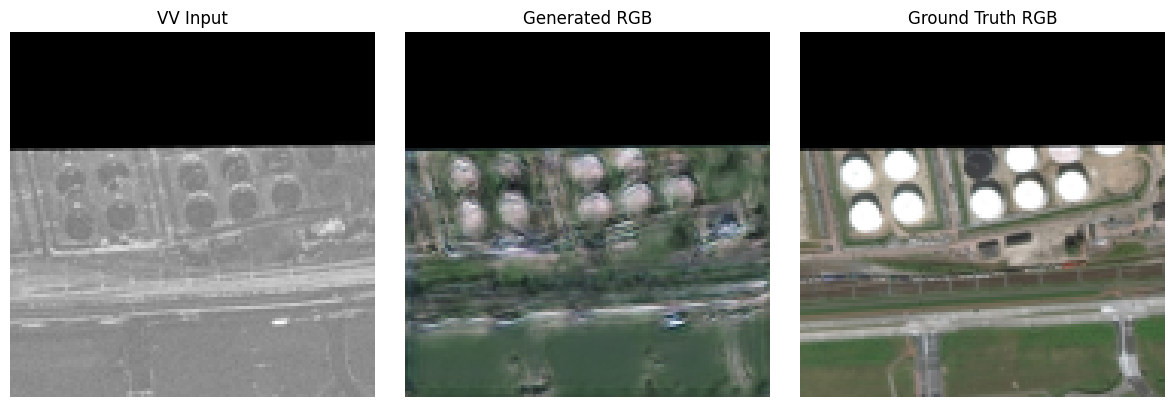

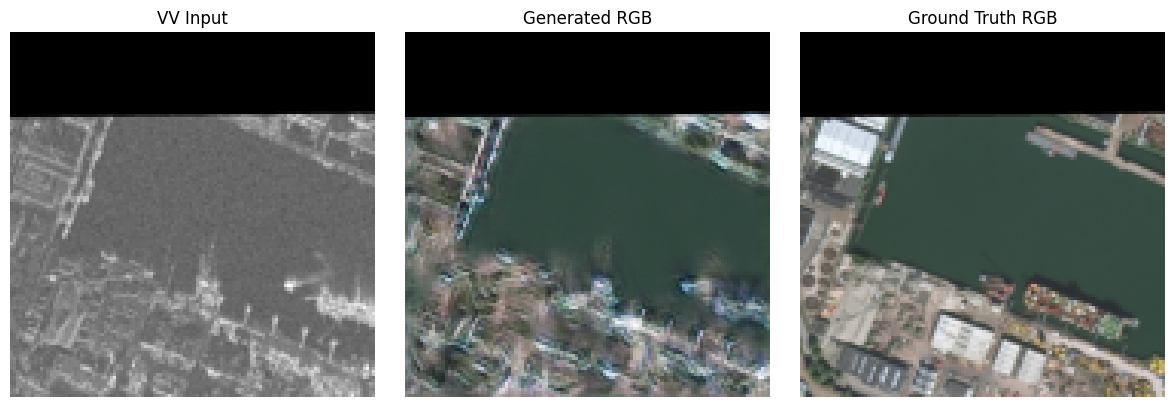

In [66]:
# Put generator in inference mode
generator.trainable = False

# Predict RGB from VV inputs
pred = generator.predict(
    test_x[:20],
    batch_size=1,
    verbose=1
)

# Visualization
for i in range(20):
    plt.figure(figsize=(12, 4))

    # VV Input
    plt.subplot(1, 3, 1)
    plt.title("VV Input")
    plt.imshow(test_x[i].squeeze(), cmap="gray")
    plt.axis("off")

    # Generated RGB
    plt.subplot(1, 3, 2)
    plt.title("Generated RGB")
    plt.imshow(np.clip(pred[i], 0, 1))
    plt.axis("off")

    # Ground Truth RGB
    plt.subplot(1, 3, 3)
    plt.title("Ground Truth RGB")
    plt.imshow(test_y[i])
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [69]:
generator.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 120, 120,  │        832 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 120, 120,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 120, 120,  │     18,496 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 120, 120,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 120, 120,  │     73,856 │ leaky_re_lu_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 120, 120,  │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 120, 120,  │    147,584 │ leaky_re_lu_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 120, 120,  │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 120, 120,  │    295,040 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 120, 120,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 192)              │            │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 120, 120,  │    110,656 │ concatenate_1[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 120, 120,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 96)               │            │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 120, 120,  │      7,203 │ concatenate_2[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 653,667 (2.49 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 653,667 (2.49 MB)